## make semi supervised

In [1]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2

Loading BokehJS ...

In [2]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [3]:
dataset = read_h5ad("temp/celligner_multi.h5ad")

In [10]:
Counter(dataset.obs.lineage)

Counter({'lung': 1359,
         'soft_tissue': 575,
         'skin': 630,
         'bile_duct': 82,
         'bladder': 473,
         'colon': 520,
         'lymphocyte': 188,
         'uterus': 278,
         'gastric': 469,
         'kidney': 1099,
         'pancreas': 299,
         'central_nervous_system': 1369,
         'fibroblast_bone': 9,
         'breast': 1323,
         'bone': 351,
         'upper_aerodigestive': 588,
         'ovary': 517,
         'cervix': 325,
         'blood': 1314,
         'esophagus': 283,
         'liver': 433,
         'peripheral_nervous_system': 245,
         'eye': 93,
         'fibroblast_skin': 7,
         'thyroid': 672,
         'plasma_cell': 29,
         'fibroblast_upper_aerodigestive': 1,
         'fibroblast_lung': 6,
         'embryo': 6,
         'fibroblast_breast': 6,
         'prostate': 663,
         'fibroblast_lymphocyte': 3,
         'fibroblast_colorectal': 3,
         'U': 207,
         'fibroblast_soft_tissue': 3,
         'a

In [11]:
for val in ['ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

ends {'paired end'}
reference {'hg38', 'hg19'}
method {'bulk'}
sequencer {'Illumina HiSeq 4000', 'Illlumina TruSeq', 'Illumina HiSeq 2000'}


In [4]:
loc = np.argsort(np.nanvar(dataset.X,0))[-3000:]
dataset = AnnData(dataset.X[:,loc], dataset.obs, dataset.var.iloc[loc])

In [374]:
# removing ultra rare samples
loc = dataset.obs["disease_type"].isin([
'Teratoma',
'Thymic Cancer',
'Nasopharyngeal Cancer',
'U',
'Endocrine Cancer',
'Pineal Cancer',
'Embryonal Cancer',
"Gallbladder Cancer"]) | dataset.obs["tissue_type"].isin([
'engineered_central_nervous_system',
'embryo',
'engineered_kidney',
'engineered_ovary',
'engineered',
'engineered_prostate',
'engineered_lung',
'adrenal_cortex',
'engineered_blood',
'engineered_breast',
'colon',
'nasopharynx',
'teratoma',
'endocrine',
'pineal'])

dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], dataset.var)

In [12]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [5]:
dataset.obs.replace({'u':'U', 'other': 'U', '': 'none'}, inplace=True)

In [6]:
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='ccle'), 'align'] = 'STAR'
dataset.obs.loc[(dataset.obs['align']=='U') & (dataset.obs['dataset']=='met500'), 'align'] = 'STAR'

In [7]:
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='ccle'), 'counter'] = 'RSEM'
dataset.obs.loc[(dataset.obs['counter']=='U') & (dataset.obs['dataset']=='met500'), 'counter'] = 'RSEM'

we can use estimation for the missing values in the conditional dataset

In [10]:
dataset.obs.loc[(dataset.obs['cell_format']=='U') & dataset.obs['dataset'].isin(['hcmi','cclf']), "cell_format"] = evaluator.adata_latent.obs.loc[dataset.obs.loc[(dataset.obs['cell_format']=='U')].index, 'cell_format_pred']

In [11]:
print(set(dataset.obs.loc[(dataset.obs['cell_format']=='U')].dataset))
dataset.obs['cell_format'] = dataset.obs['cell_format'].cat.rename_categories({'U':'none'})

{'met500', 'tcga'}


In [12]:
print(set(dataset.obs.loc[(dataset.obs['conservation']=='U')].dataset))
dataset.obs['conservation'] = dataset.obs['conservation'].cat.rename_categories({'U':'none'})

{'met500', 'tcga'}


In [25]:
(np.isnan(dataset.X).sum(0)>3000).sum()

236

In [ ]:
cl2 = celligner2.CELLIGNER2(
    adata=dataset.copy(),
    condition_keys=['dataset','reference','sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format'],
    predictor_keys=['lineage', 'collection_site', 'age', "sex", 'disease_type', 'doublingt' , 'cell_type', 'morphology', 'ethnicity', 'instability', 'hasebv', 'base_media', 'stage','passage_number','contamination'],
    hidden_layer_sizes=[1024 ,512, 128, 64],
    classifier_hidden_layer_sizes=[32, 64, 128],
    use_mmd = True,
    latent_dim=24,
    beta=100,
    betaclass=0.6,
    #mmd_on='y1'
    #recon_loss="mse",
)
cl2.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 50,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.2,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 1024 27
	Hidden Layer 1 in/out: 1024 512
	Hidden Layer 2 in/out: 512 128
	Hidden Layer 3 in/out: 128 64
	Mean/Var Layer in/out: 64 24
Classifier Architecture:
	First Layer in/out:  24 32
	Hidden Layer 1 in/out: 32 64
	Hidden Layer 2 in/out: 64 128
	Output Layer in/out:  128 425 

Decoder Architecture:
	First Layer in, out and cond:  24 64 27
	Hidden Layer 1 in/out: 64 128
	Hidden Layer 2 in/out: 128 512
	Hidden Layer 3 in/out: 512 1024
	Output Layer in/out:  1024 3000 

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
The

In [40]:
cl2.save('./temp/model', overwrite=True)

In [37]:
# doesn't work, the model then outputs nans as latent factors.
cl2 = celligner2.CELLIGNER2.load(dir_path='./temp/model', adata=dataset)

AnnData object with n_obs × n_vars = 15064 × 3000
    obs: 'collection_site', 'disease_type', 'doublingt', 'method', 'reference', 'age', 'cell_type', 'ends', 'sequencer', 'participant_id', 'sex', 'base_media', 'morphology', 'dataset', 'ethnicity', 'instability', 'hasebv', 'tissue_id', 'sample_type', 'align', 'counter', 'passage_number', 'contamination', 'lineage', 'stage', 'conservation', 'cell_format', 'celligner2_size_factors'


TypeError: __init__() got an unexpected keyword argument 'input_dim'

In [14]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2)

we have a certain distribution of passage numbers only based on CCLF samples. looking at CCLE we expect high passages considerign they are historical cell lines. this is what we get

In [103]:
Counter(obs[(obs['passage_number']!="U")]['passage_number'])

Counter({'none': 12236, 'verylow': 6, 'medium': 39, 'high': 31, 'low': 14})

In [100]:
obs = evaluator.adata_latent.obs
Counter(obs[(obs['passage_number']=="U") & (obs.dataset=="ccle")]['passage_number_pred'])

Counter({'none': 766, 'high': 142, 'medium': 494, 'verylow': 9})

then it doesn't make any sense on tcga (we would expect low if anything else)

In [102]:
Counter(obs[(obs['passage_number']=="none") & (obs.dataset=="tcga")]['passage_number_pred'])

Counter({'none': 12236})

In [15]:
evaluator.get_class_quality(classes=['lineage', 'collection_site', 'age', "sex", 'disease_type', 'doublingt', 'cell_type', 'base_media', 'morphology', 'ethnicity', 'instability', 'hasebv', 'passage_number', 'contamination', 'stage'])

lineage
all predicted categories:  {'blood', 'esophagus', 'germ_cell', 'cervix', 'breast', 'bladder', 'gastric', 'ampulla of vater', 'peripheral_nervous_system', 'skin', 'colon', 'brain', 'gall_bladder', 'uterus', 'liver', 'pancreas', 'lung', 'upper_aerodigestive', 'testis', 'adrenal', 'thyroid', 'soft_tissue', 'bone', 'kidney', 'central_nervous_system', 'ovary', 'prostate', 'lymphocyte'}
accuracy:  0.8207578919028068
F1 Score: 0.41


collection_site
all predicted categories:  {'pancreatic_head', 'blood', 'cerebellum', 'fibroblast', 'esophagus', 'breast', 'post_mortem_blood', 'urinatract', 'cerebrum', 'colon', 'brain', 'ascites', 'biliatract', 'upper_lobe_lung', 'endometrium', 'lymph_node', 'liver', 'bone_marrow', 'pancreas', 'lung', 'ampulof_vater', 'ileum', 'thoracic', 'sigmoid_colon', 'common_biduct', 'peritoneal', 'upper_aerodigestive_tract', 'soft_tissue', 'thyroid', 'bone', 'eye', 'rectosigmoid_junction', 'haematopoietic_and_lymphoid_tissue', 'kidney', 'central_nervous_system', '

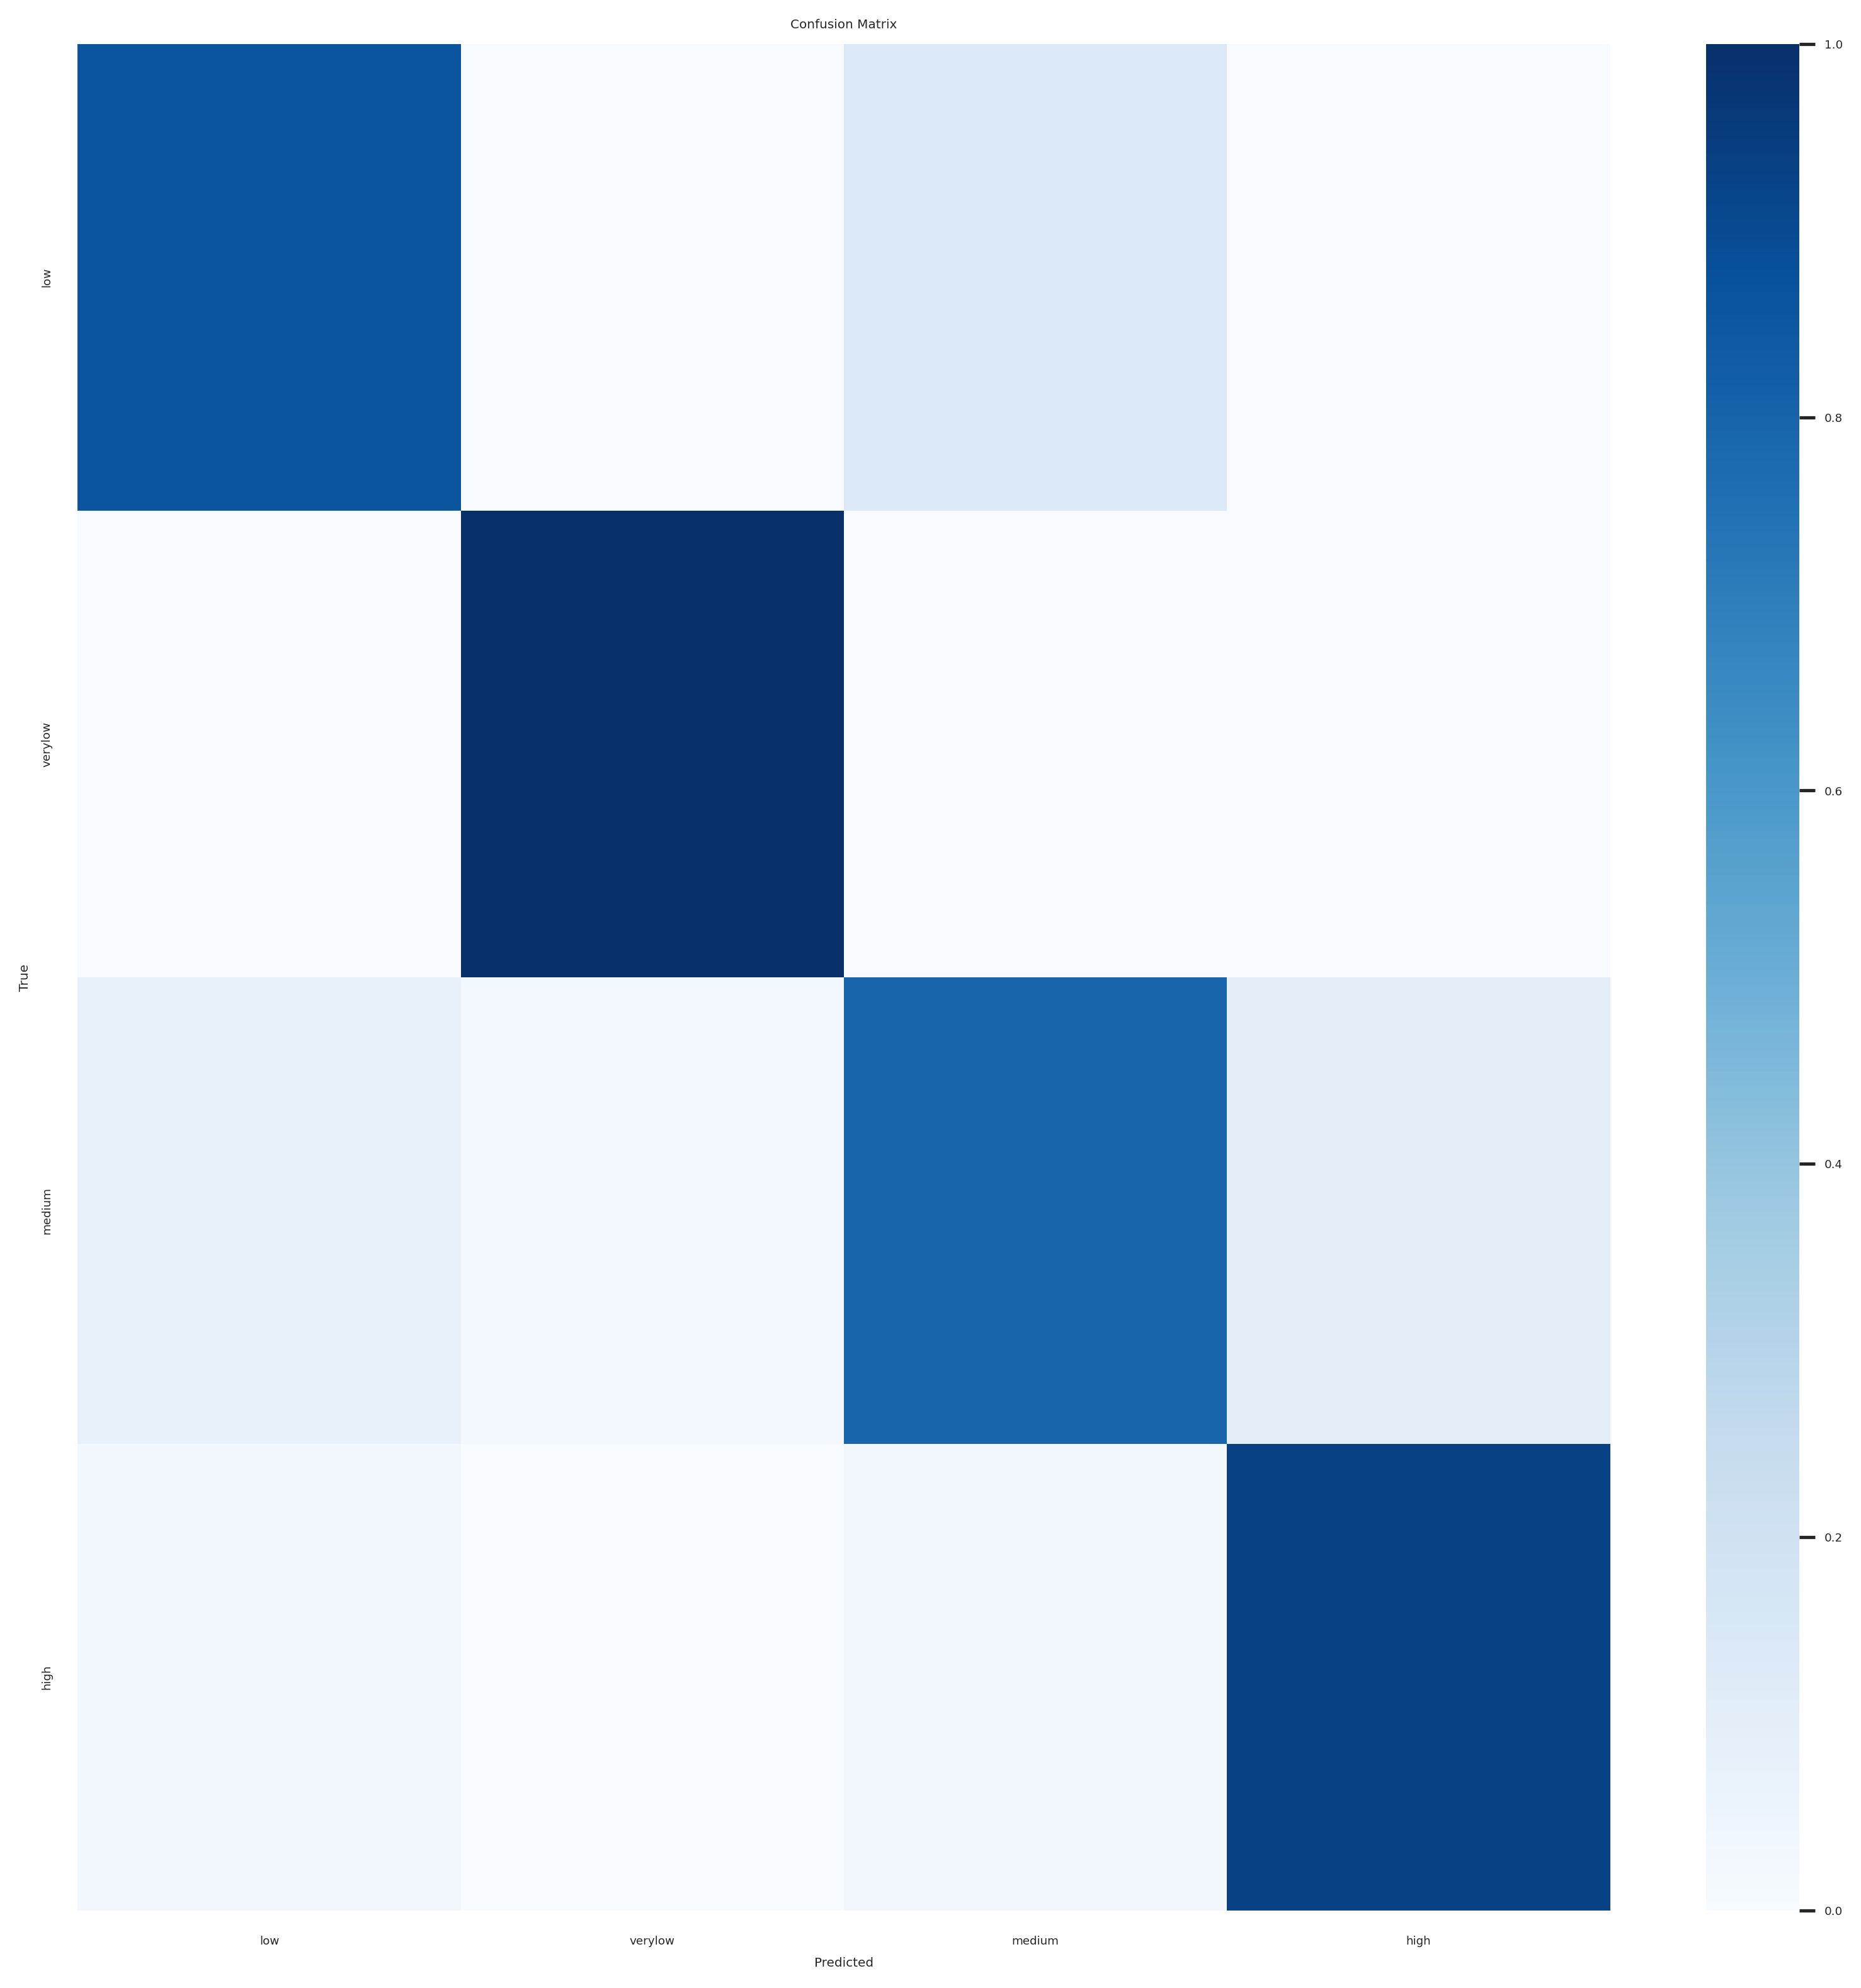

In [175]:
conf = evaluator_less.getconfusionMatrix(on="passage_number", only=None)

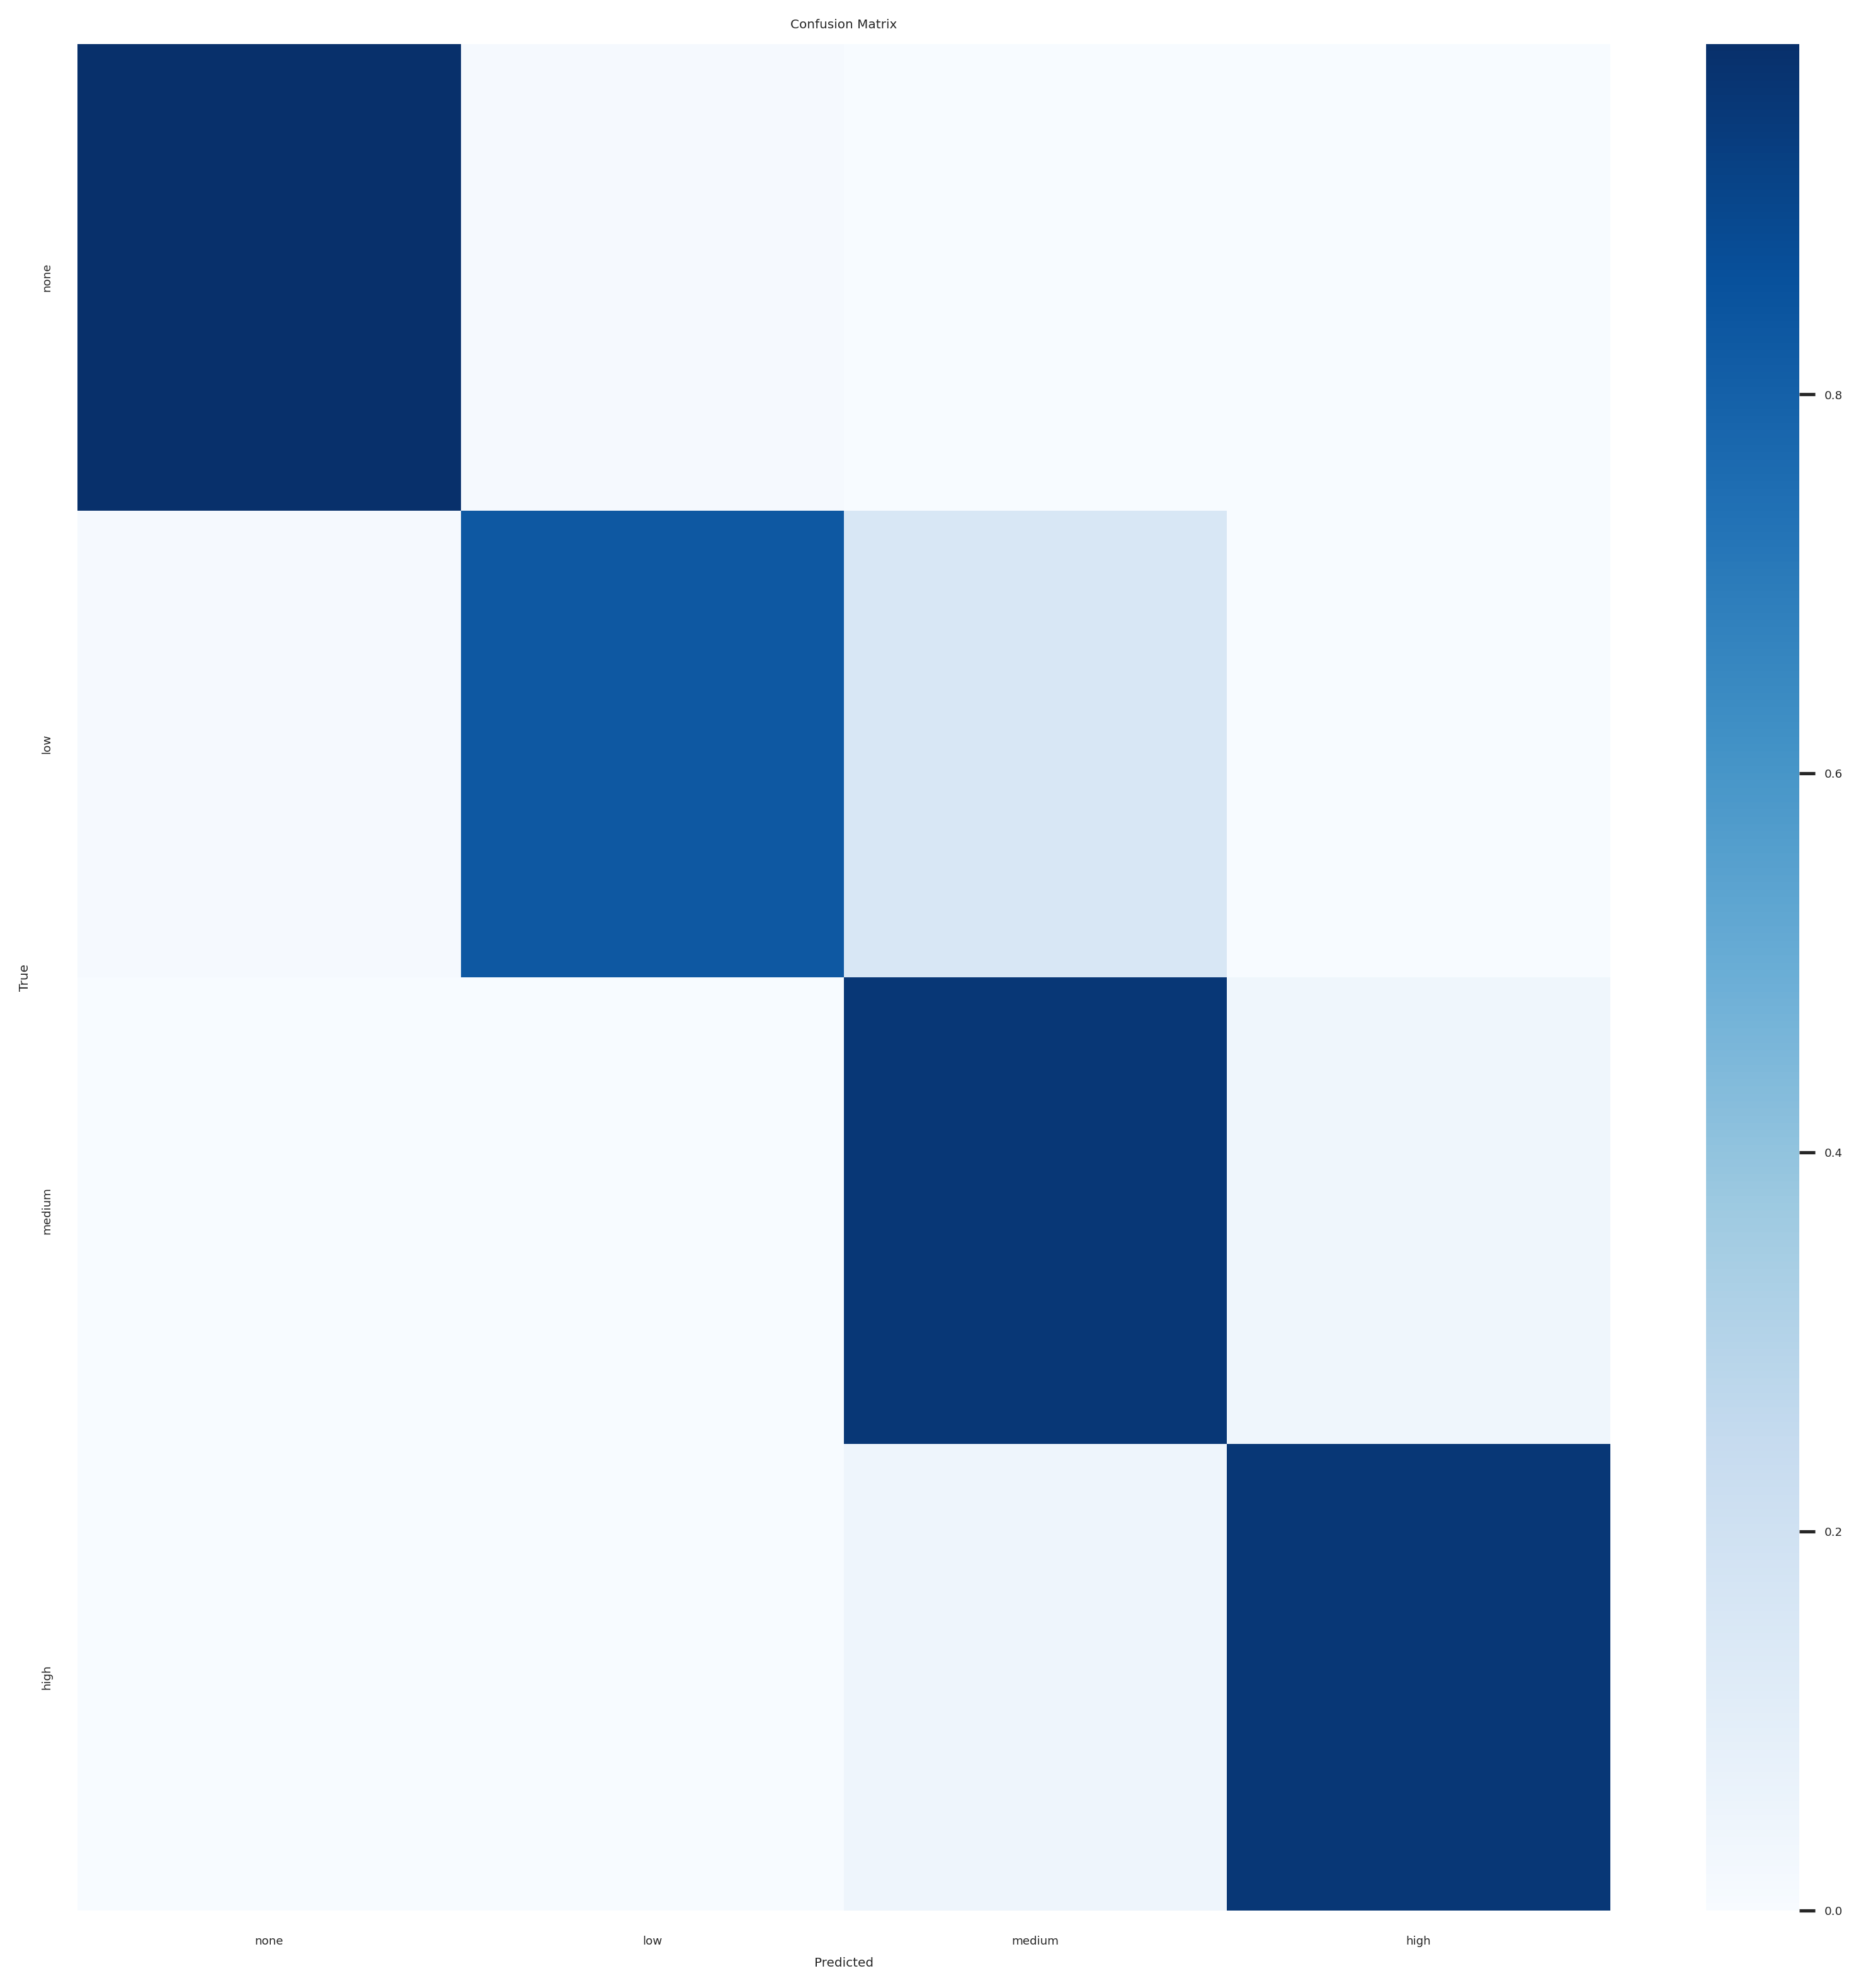

In [176]:
conf = evaluator_less.getconfusionMatrix(on="contamination", only=None)

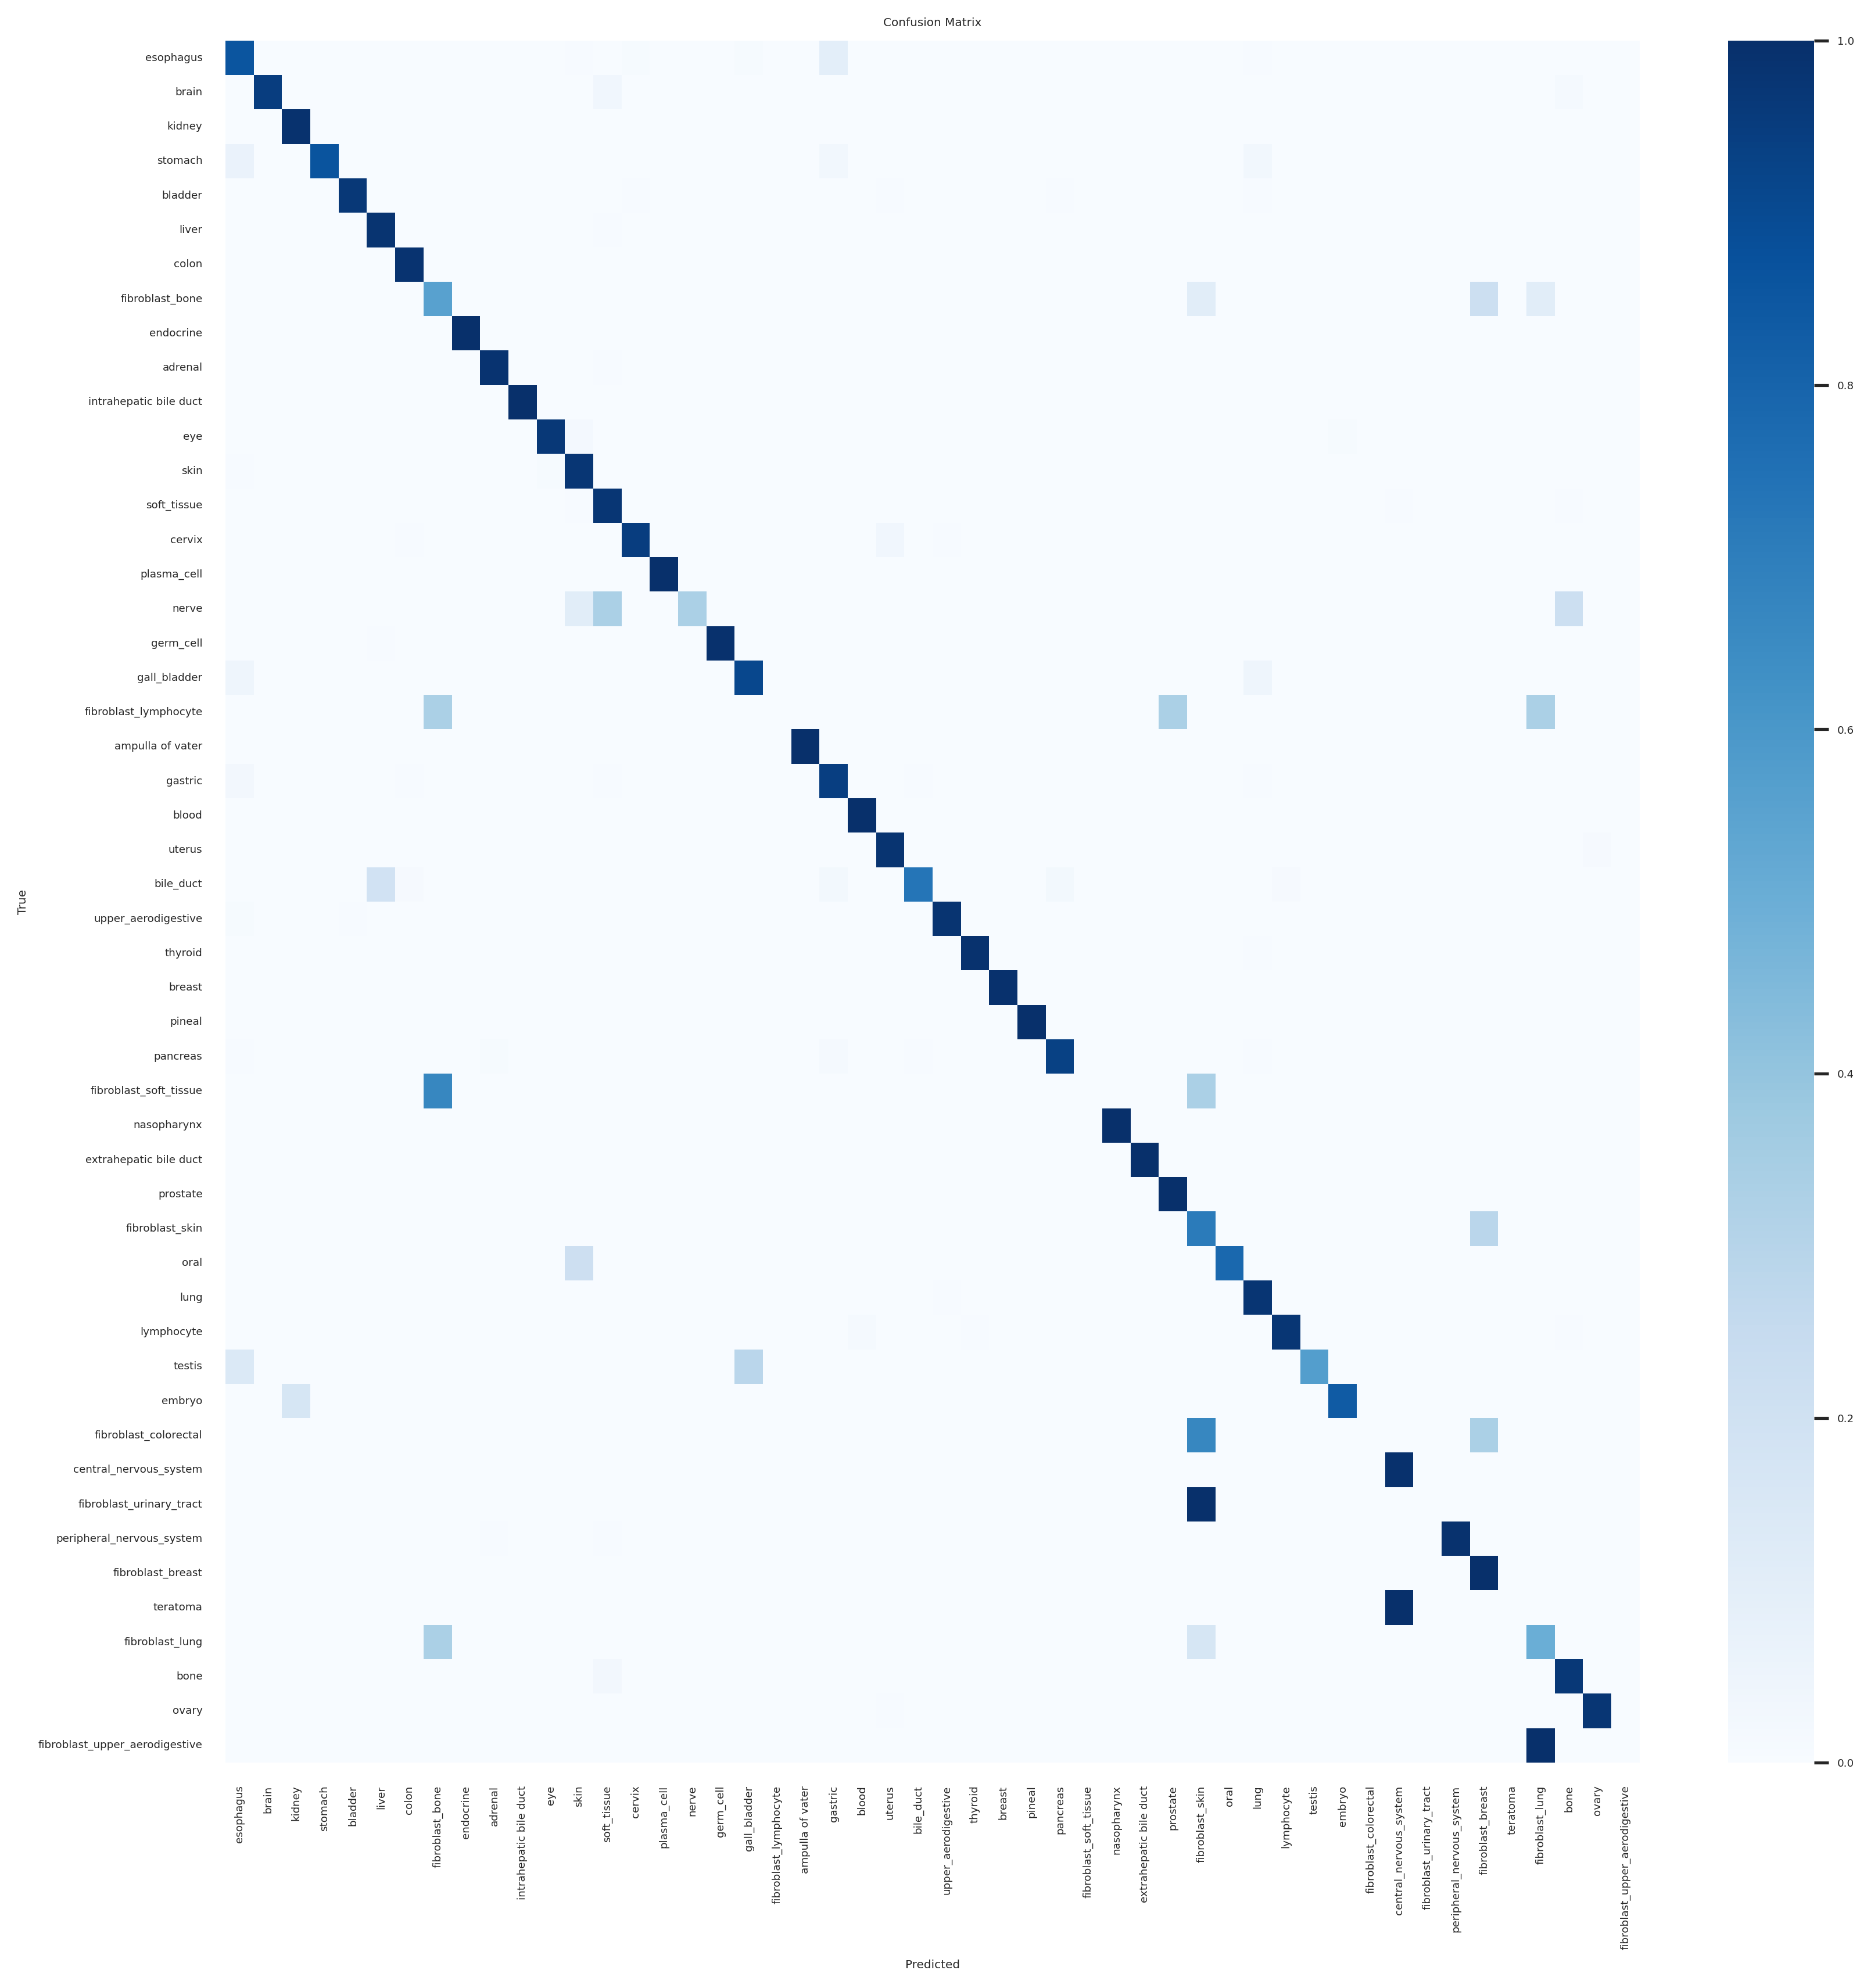

In [211]:
conf = evaluator_less.getconfusionMatrix(on="lineage", only=None)

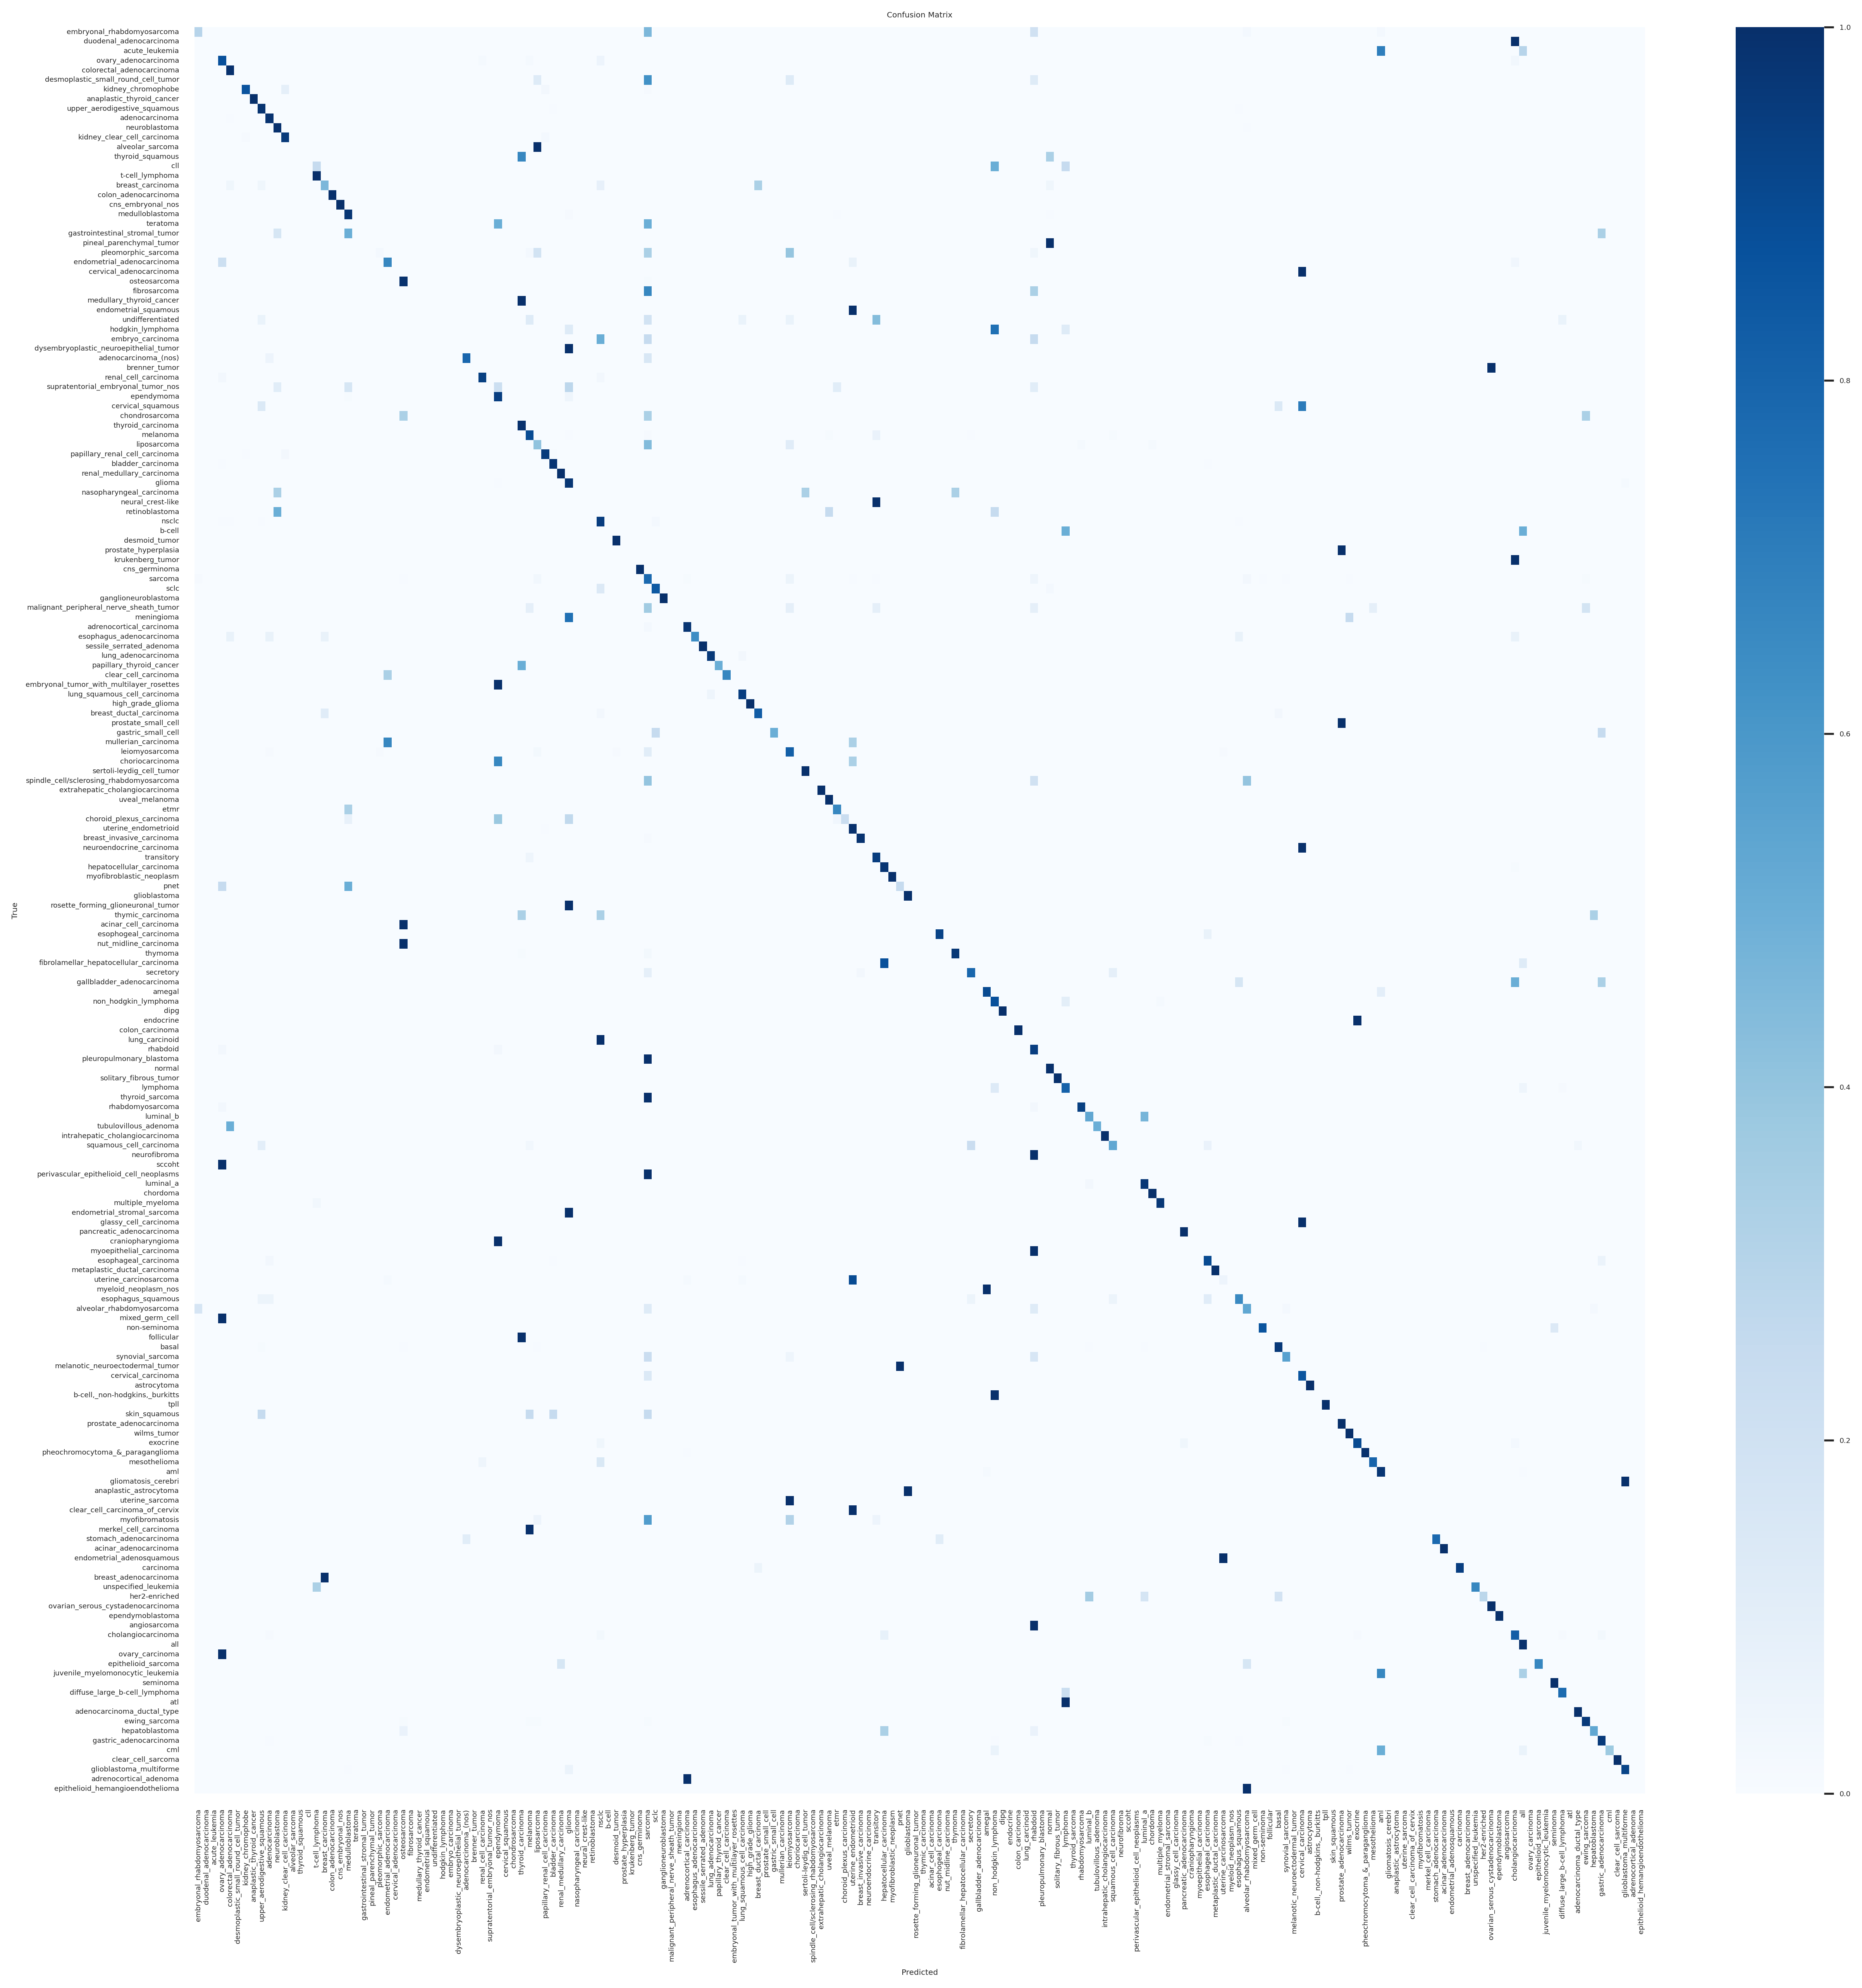

In [165]:
conf = evaluator.getconfusionMatrix(on="disease_type", only=None, figsize=(20,20), font_scale=3)

In [176]:
np.isnan(evaluator.adata_latent.x).sum()

0

In [207]:
evaluator.adata_latent = AnnData(evaluator.adata_latent.X, obs = evaluator.adata_latent.obs, var = evaluator.adata_latent.var) 

In [211]:
evaluator.adata_latent.obs = evaluator.adata_latent.obs.astype(str) 

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'collection_site' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'disease_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated an

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'lineage' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stage' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remov

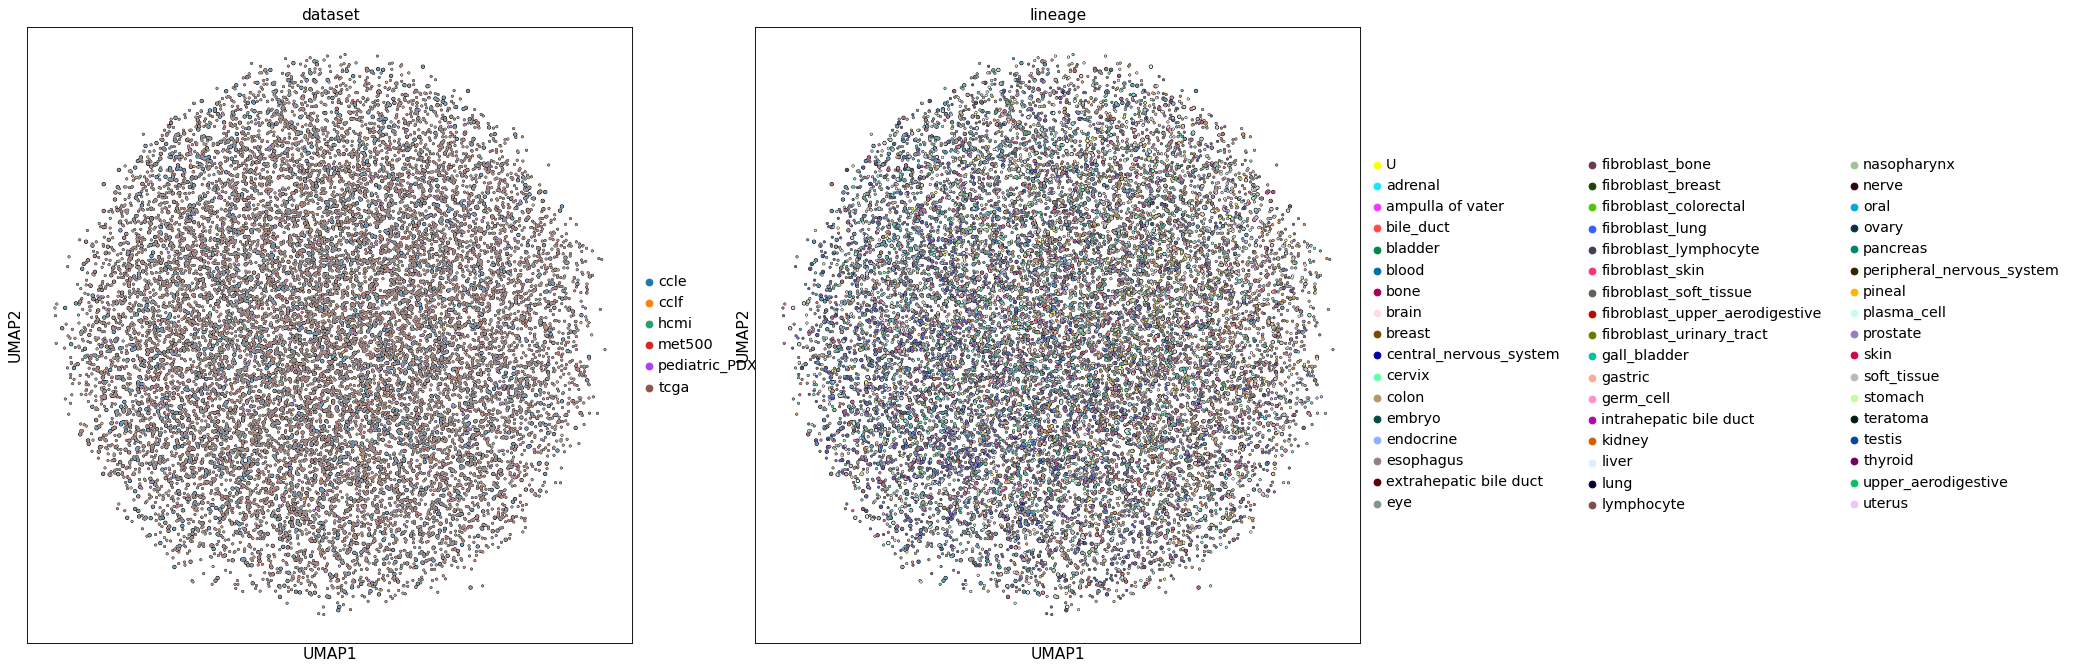

In [16]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=.5,
                            alpha=1,
                            spread=1,
                            random_state=None),
        color=['dataset', 'lineage'],
        projection="2d",
        n_neighbors=8,
        add_outline=True,
        size=[20]*len(dataset[dataset.obs['dataset']!='tcga']) + [10]*len(dataset[dataset.obs['dataset']=='tcga']))

/home/jeremie/celligner2/celligner2/plotting/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


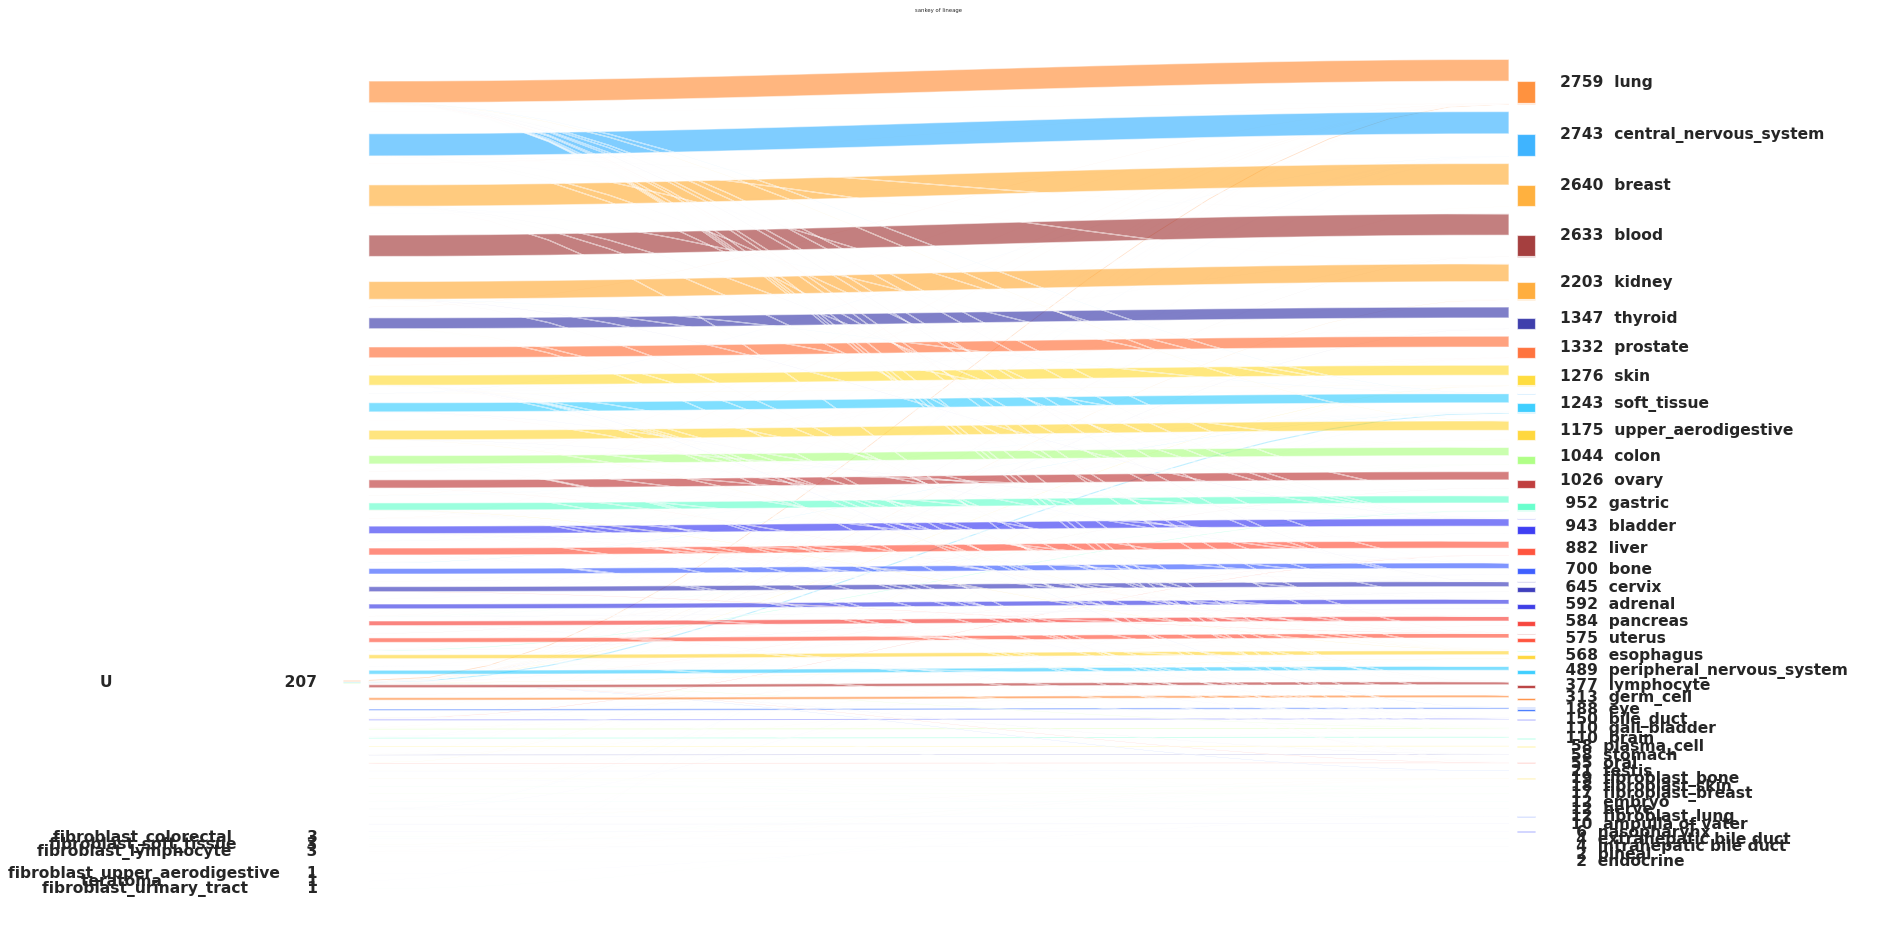

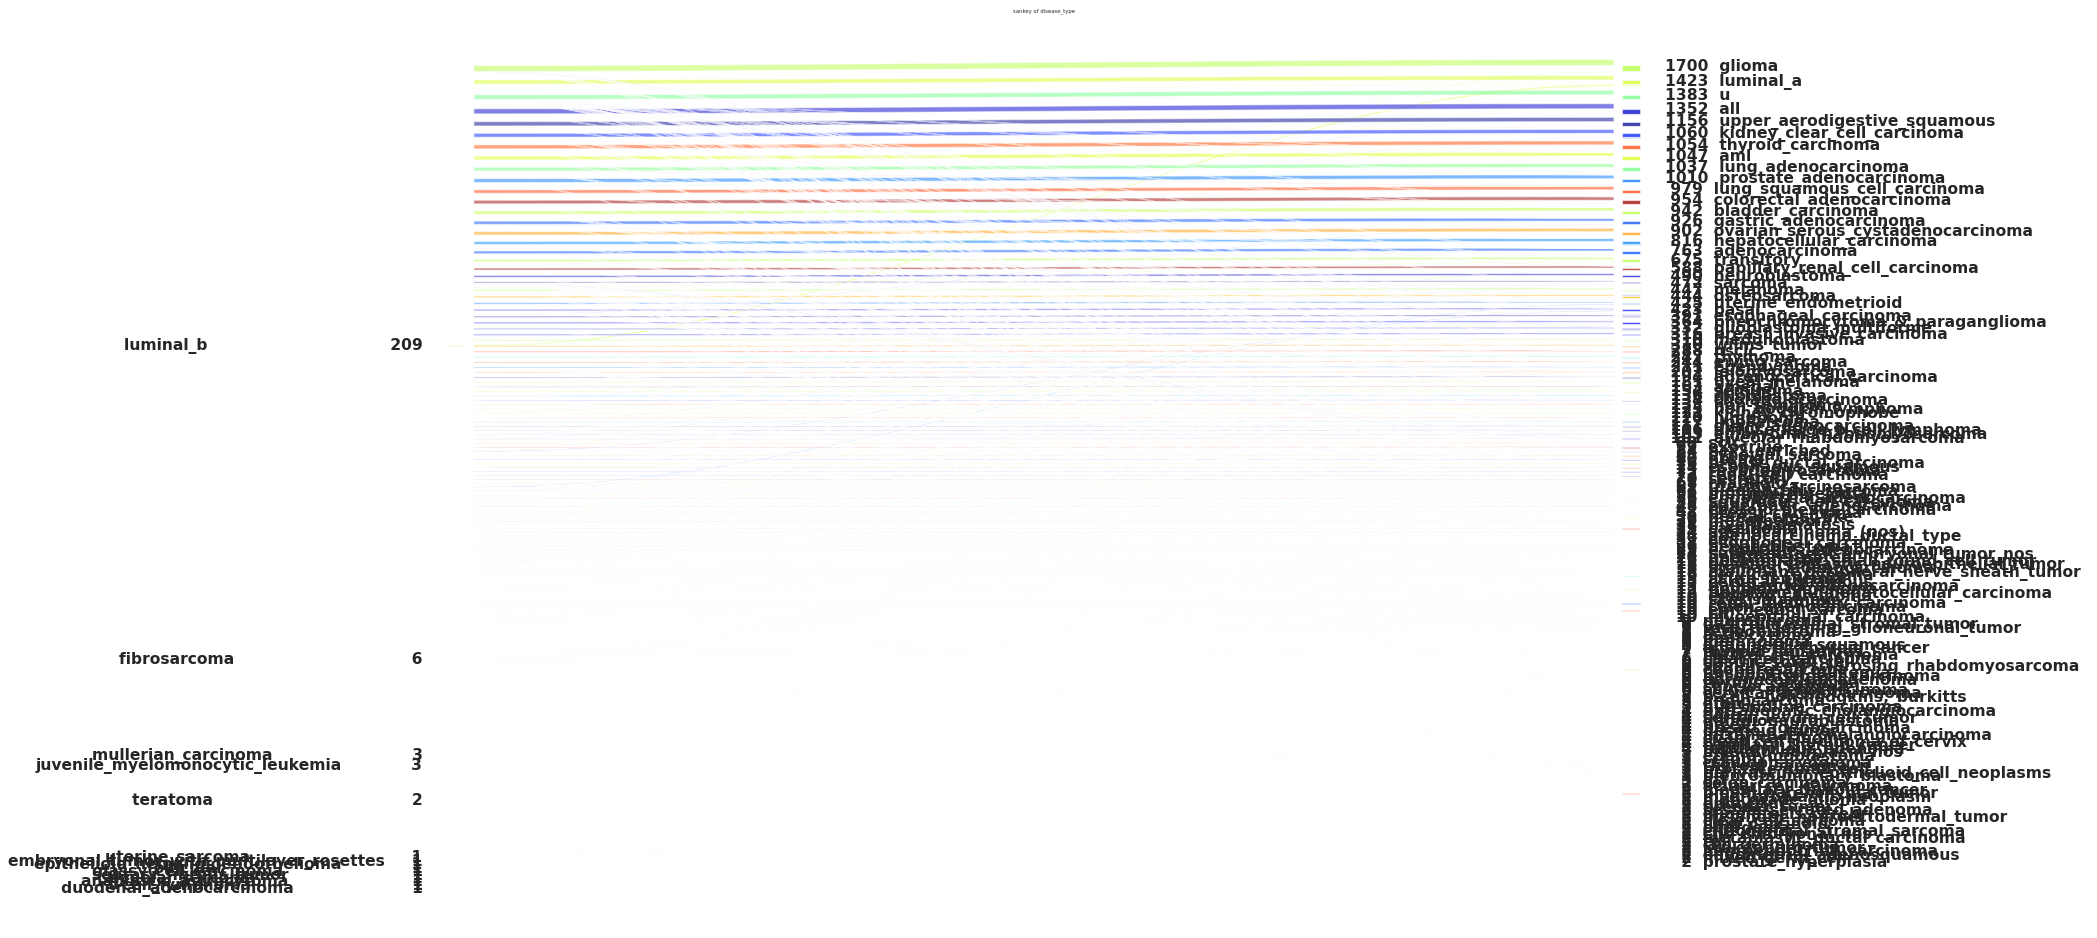

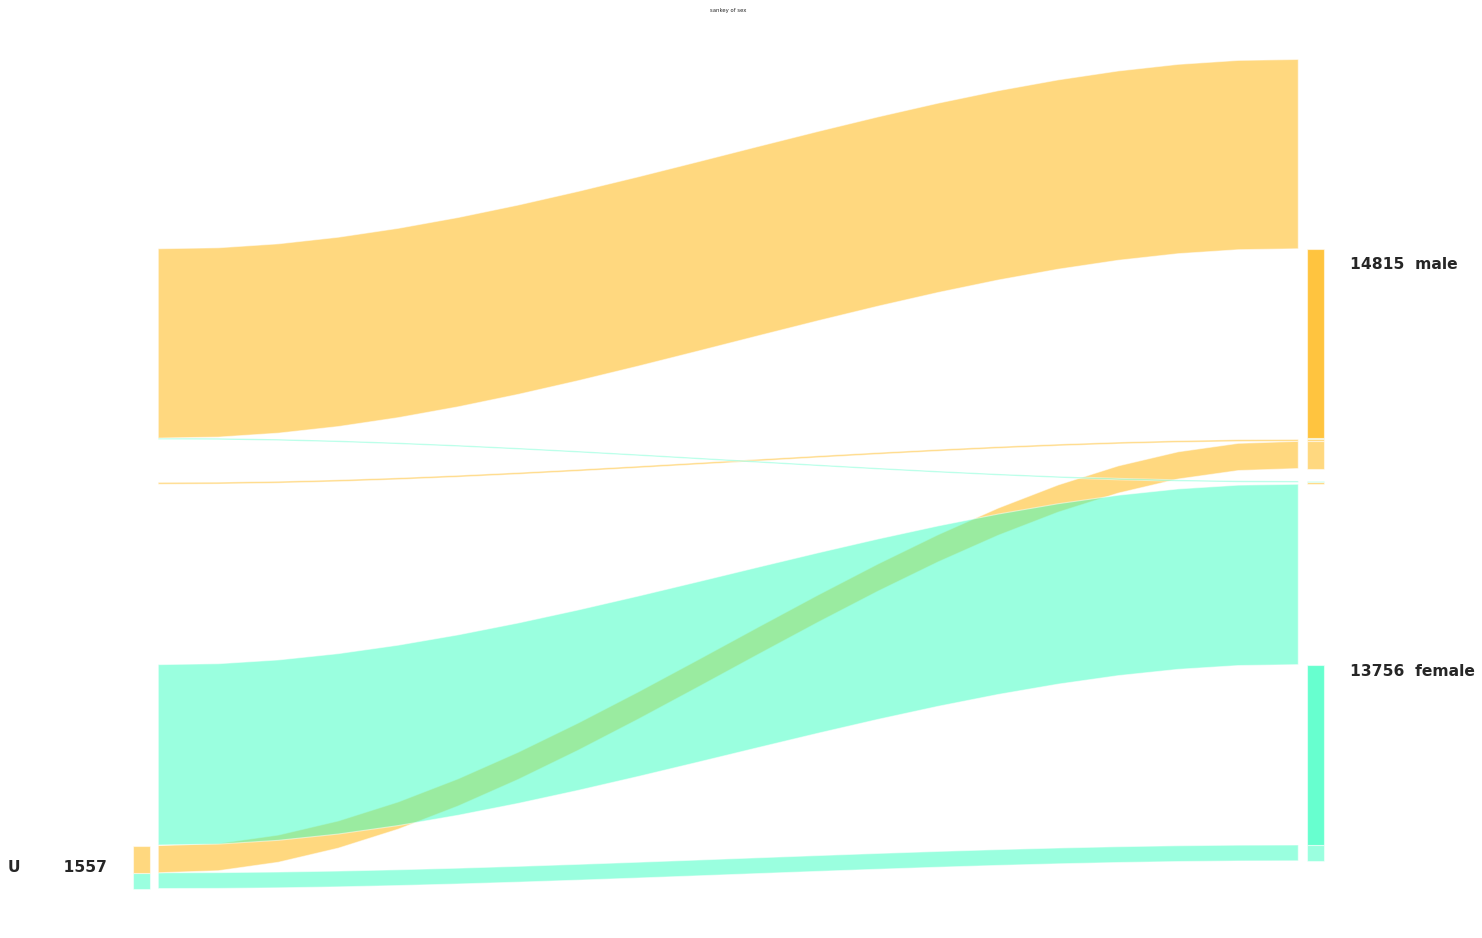

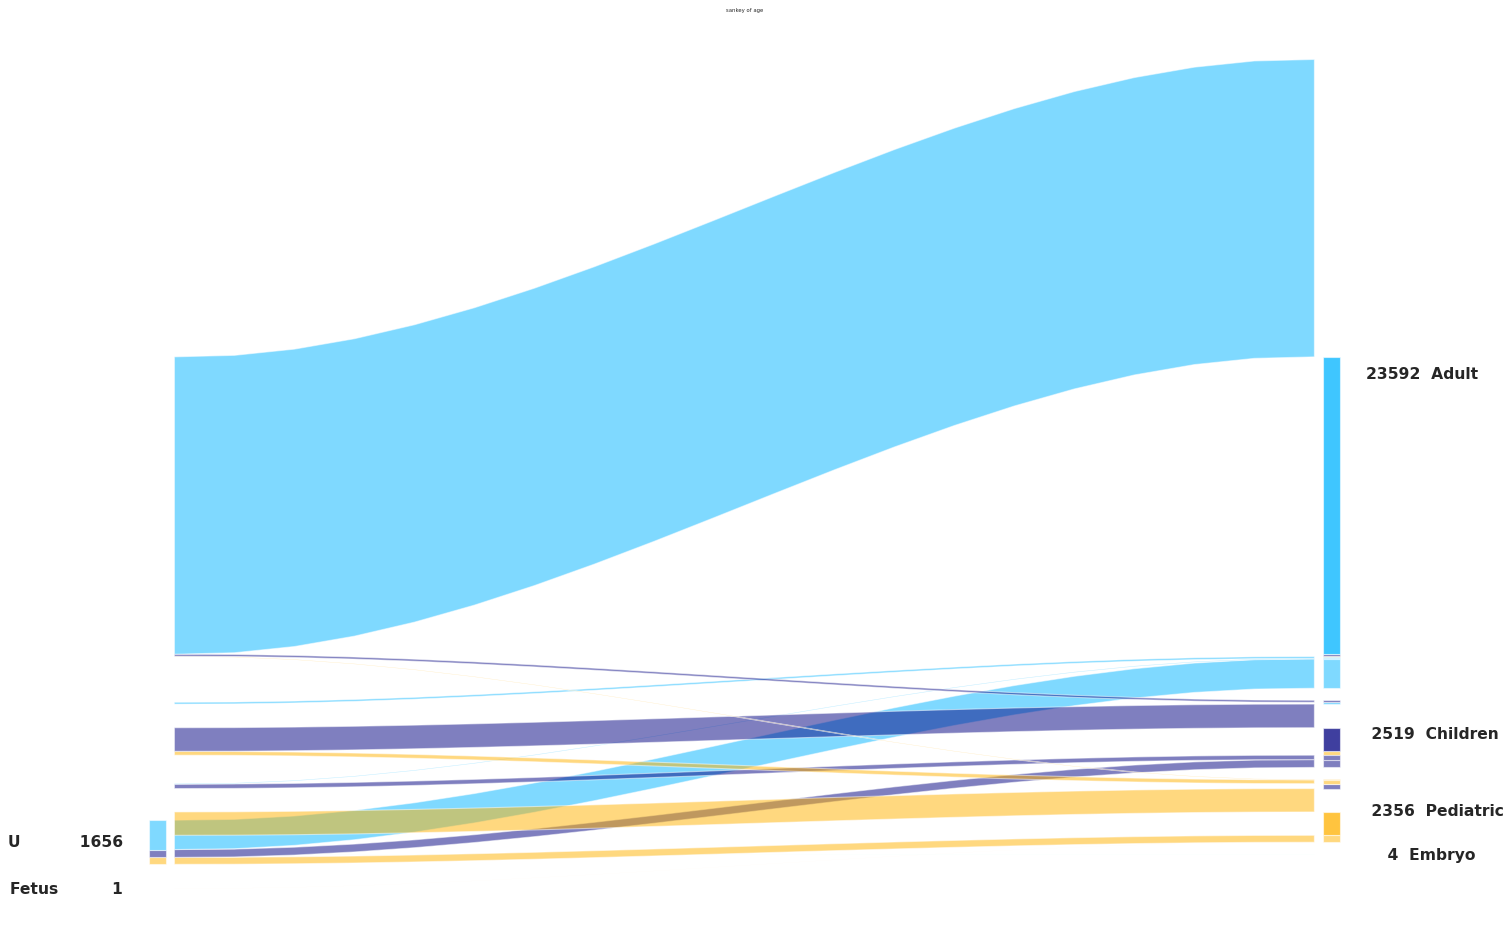

In [218]:
evaluator.plot_classification(classes=['lineage', 'disease_type', 'sex', 'age'])

In [ ]:
evaluator.plot_history()

In [225]:
evaluator.get_asw(label_key='lineage')
evaluator.get_latent_score(label_key='lineage')
evaluator.get_nmi(label_key='lineage')

silhouette score...
ASW on batch: 0.8997235557965478
ASW on celltypes: 0.4701786618679762
Calculating EBM with n_cat = 51
Latent-Space Score EBM+KNN, EBM, KNN: 0.64, 0.45, 0.19


KeyboardInterrupt: 

In [158]:
## what would it look like as tumor
#print(cl2_less.adata.obs.iloc[:100])
size = 20
cols = ['dataset','reference','sequencer', 'sample_type', 'align', 'counter', 'conservation', 'cell_format']

tcga_cond = pd.DataFrame(data=[evaluator.adata_latent.obs.loc[obs.dataset=='tcga', cols].iloc[0].values.tolist()]*size, columns=cols)

ccle_cond = pd.DataFrame(data=[evaluator.adata_latent.obs.loc[obs.dataset=='ccle', cols].iloc[0].values.tolist()]*size, columns=cols)

reco_tumor = cl2.reconstruct(evaluator.adata_latent[:size].X, tcga_cond)
reco = cl2.reconstruct(evaluator.adata_latent[:size].X, ccle_cond)
true = cl2.adata[:size].X

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [159]:
reco.columns = dataset.var.index
reco = AnnData(reco, cl2.adata.obs.iloc[:size], dataset.var)
reco_tumor.columns = dataset.var.index
reco_tumor = AnnData(reco_tumor, cl2.adata.obs.iloc[:size], dataset.var)
true.columns = dataset.var.index
true = AnnData(true, cl2.adata.obs.iloc[:size], dataset.var)

In [160]:
name = true.obs.index.tolist() + [i+"_reco" for i in reco.obs.index]
coeff = pd.DataFrame(data=np.corrcoef(true.X, reco.X), columns = name, index = name)

<AxesSubplot:>

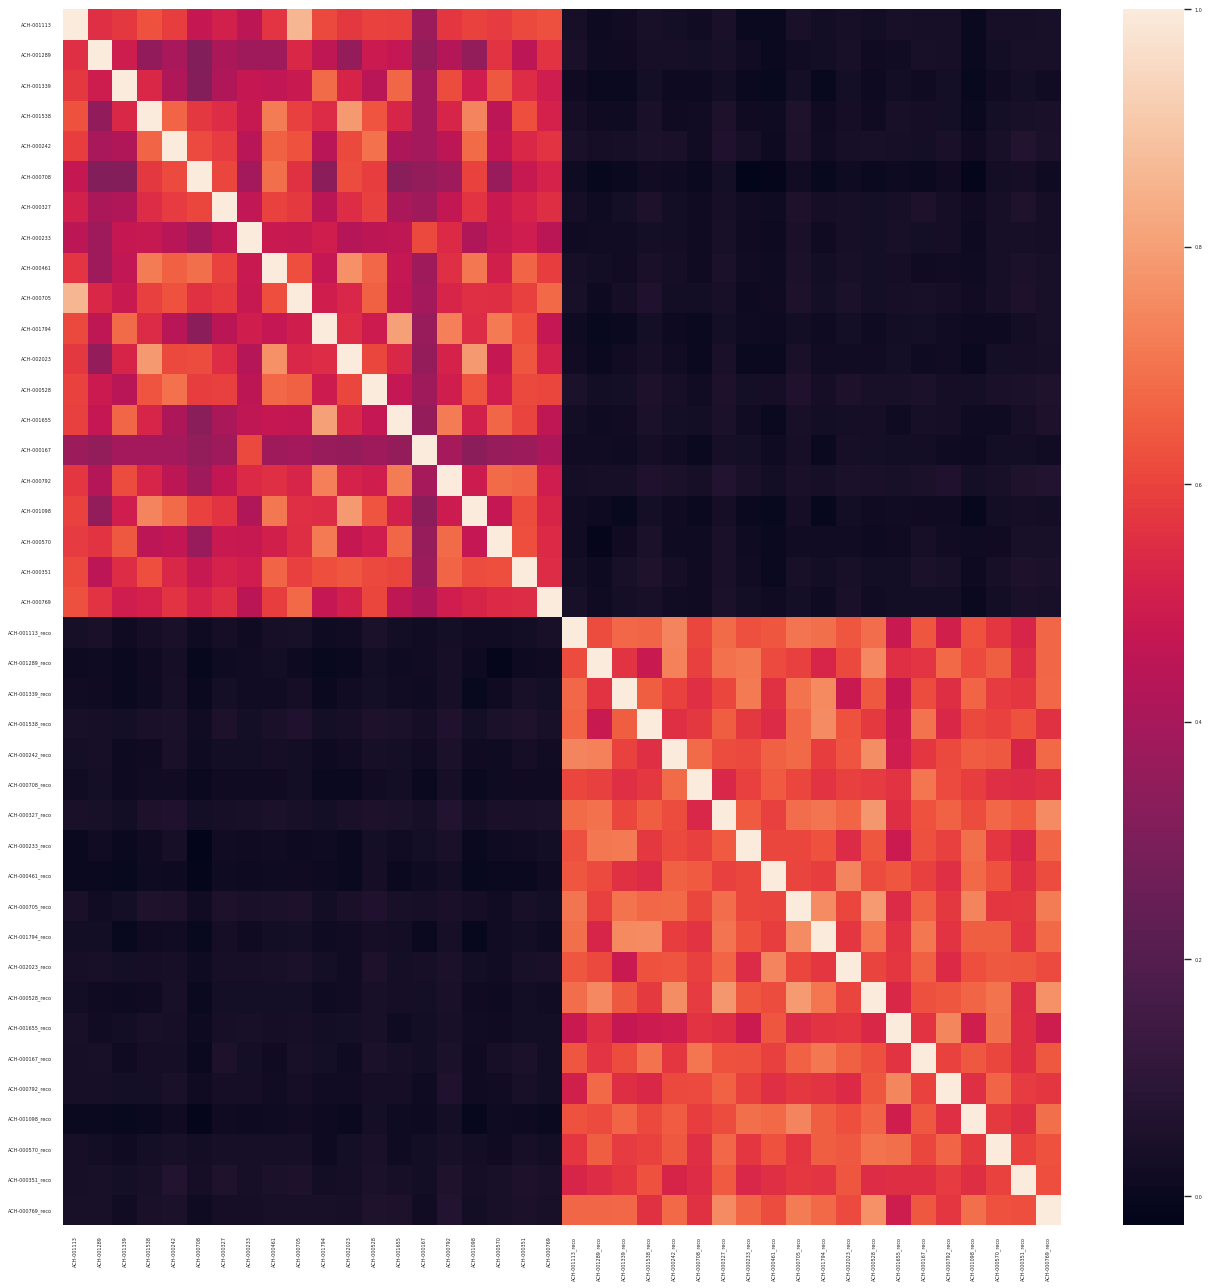

In [161]:
import seaborn as sns 
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(coeff, ax=ax)

In [213]:
sa = cl2.adata.obs
clloc = sa[(sa.lineage=='gastric')&(sa.dataset=='ccle')].index[:size]
tmloc = sa[(sa.lineage=='gastric')&(sa.dataset=='tcga')].index[:size]

In [214]:
reco_tumor = cl2.reconstruct(evaluator.adata_latent[clloc].X, tcga_cond)
reco = cl2.reconstruct(evaluator.adata_latent[clloc].X, ccle_cond)
true = cl2.adata[clloc].X
tumor_eq = cl2.adata[tmloc].X

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [215]:
reco.columns = dataset.var.index
reco = AnnData(reco, cl2.adata.obs.loc[clloc], dataset.var)
reco_tumor.columns = dataset.var.index
reco_tumor = AnnData(reco_tumor, cl2.adata.obs.loc[clloc], dataset.var)
true.columns = dataset.var.index
true = AnnData(true, cl2.adata.obs.loc[clloc], dataset.var)
tumor_eq.columns = dataset.var.index
tumor_eq = AnnData(tumor_eq, cl2.adata.obs.loc[tmloc], dataset.var)

In [216]:
name = true.obs.index.tolist() + [i+"_reco" for i in reco.obs.index] + [i+"_reco_tumor" for i in reco.obs.index] + tumor_eq.obs.index.tolist()
coeff = pd.DataFrame(data=np.corrcoef(np.vstack([true.X,reco.X,reco_tumor.X, tumor_eq.X])), columns = name, index = name)

In [217]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],true.obs.index.tolist()].mean().mean()

-0.0018391048862532425

In [218]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],tumor_eq.obs.index.tolist()].mean().mean()

0.004821794207404971

In [219]:
coeff.loc[[i+"_reco_tumor" for i in reco.obs.index],[i+"_reco" for i in reco.obs.index]].mean().mean()

0.6377327742937398

<AxesSubplot:>

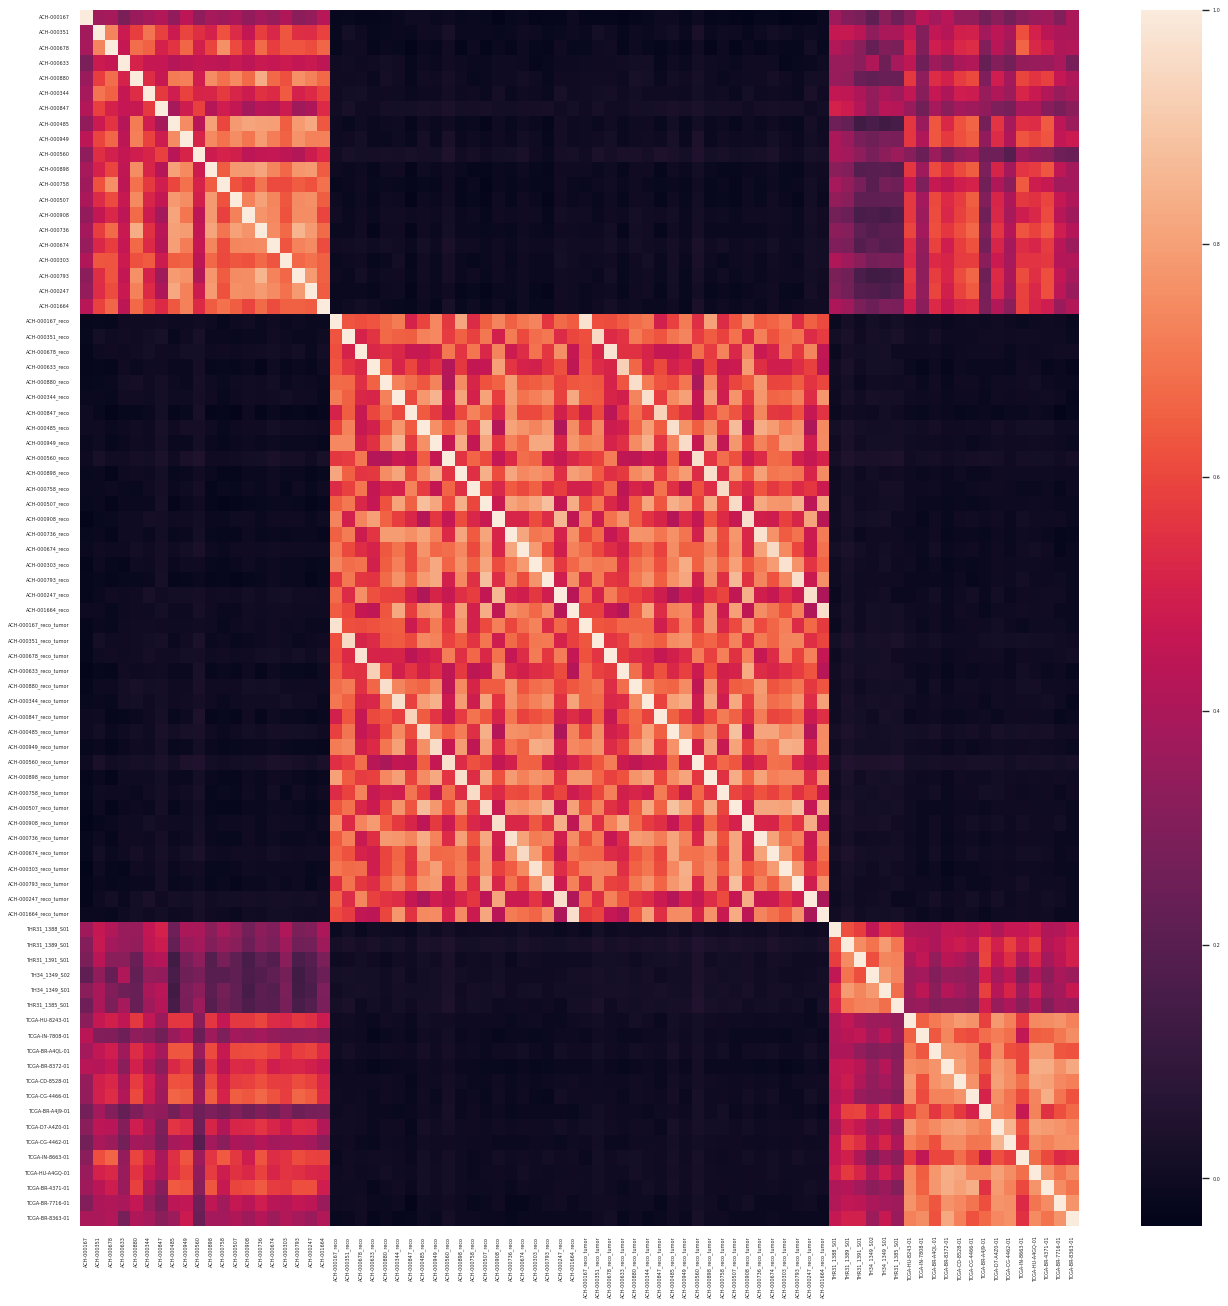

In [220]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(coeff, ax=ax)

39,000,000 input 

811,852 parameter

## zenodo

In [ ]:
ACCESS_TOKEN = "YOURTOKEN"
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN,
                                             upload_type="other",
                                             title='Celligner2',
                                             description='test CL2 upload',
                                             creators=[
                                                 {"name": "Jeremie, Kalfon", 
                                                  "affiliation": "Broad Institute", 
                                                  "orcid": ""},
                                             ]
                                             )

In [ ]:
download_link = sca.zenodo.upload_model('./model/cl2',
                                        deposition_id=deposition_id,
                                        access_token=ACCESS_TOKEN,
                                        model_name='CL2')

In [ ]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

In [ ]:
model_path = sca.zenodo.download_model(download_link, './surg_model/', make_dir=True)
new_cl2 = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=model_path)